## This notebook demonstrates the usage of SIDMpy, a python package to compute the central density of SIDM halos using a simple Jeans argument presented by Kaplinghat et al. 2016

In [1]:
from sidmpy.sidmpy import solve_from_NFW_params
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15

In the cell below, we'll compute the central density of a cored halo $\rho_0$ using the prescription first described by Kaplinghat et al. 2016. We'll turn plotting on to visualize the solution space for the central density $\rho_0$ and 
the central velocity dispersion $\sigma_v$. The colors indicate the goodness of fit for combination of $\sigma_v$ and $\rho_0$. The solver will iterate until a solution is found with fit quality ~ 0.01, or one percent accuracy imposed on the boundary conditions for the SIDM halo profile (see Kaplinghat et al 2016).  

### Solving for the core density

Simulations show that SIDM particles will thermalize the center of halos and produce mass profiles with spatially-constant velocity dispersions. Combining the Jeans equation with the Poisson equation with a spatially-constant $v_{\rm{rms}}$ gives a differential equation for the density profile 

\begin{equation}
v_{\rm{rms}}^2 \nabla^2 \log \rho_{\rm{SIDM}} = -4 \pi G \rho_{\rm{SIDM}} \quad (\rm{Eqn}. 1)
\end{equation}

where $v_{\rm{rms}}$ is the central velocity dispersion. We can solve this with boundary conditions $\rho_{\rm{SIDM}}\left(0\right) = \rho_{\rm{core}}$ and $\rho^{\prime}_{\rm{SIDM}}\left(0\right) = 0$, except we don't actually know the core density or the velocity dispersion. 

To solve for $\rho_{\rm{core}}$ and $v_{\rm{rms}}$, we first identify a radius $r_1$ where particles scatter once per Hubble time in an NFW profile. $r_1$ satisfies 

\begin{equation}
\rho_{\rm{NFW}}\left(r_1\right) \ \langle \sigma\left(v\right) v \rangle \ t_{\rm{halo}} = 1 \quad (\rm{Eqn}. 2)
\end{equation}

where $\langle \sigma\left(v\right) v \rangle$ is proportionl to the scattering weight and is given by 

\begin{equation}
\langle \sigma\left(v\right) v \rangle = \frac{1}{2 \sqrt{\pi} v_{\rm{rms}}^{3}} \int_{0}^{\infty} \sigma\left(v\right) v \times v^2 \exp \big\{-\frac{v^2}{4 v_{\rm{rms}}^2}  \big\} dv
\end{equation}
assuming the SIDM particles are in equilibrium and have MWB distribution. 

We then impose two boundary conditions on the mass profile: 

\begin{eqnarray}
M_{\rm{NFW}} \left(r < r_1 \right) &=& M_{\rm{SIDM}}\left(r < r_1 \right) \quad (\rm{Eqn}. 3) \\ \\
\rho_{\rm{NFW}} \left(r_1\right) &=& \rho_{\rm{SIDM}} \left(r_1\right) \quad (\rm{Eqn}. 4)
\end{eqnarray}

STEPS:

1) Guess values of $\rho_{\rm{core}}$ and $v_{\rm{rms}}$

2) Solve Equation 1 using the boundary conditions $\rho_{\rm{SIDM}}\left(0\right) = \rho_{\rm{core}}$ and $\rho^{\prime}_{\rm{SIDM}}\left(0\right) = 0$

3) Use the guess for $v_{\rm{rms}}$ to solve for $r_1$ using Equation 2

4) Check if the matching conditions in Equations 3 and 4 are satisfied; if they are not, try again with new $\rho_{\rm{core}}$ and $v_{\rm{rms}}$

In [5]:
### specify the parameters describing an NFW halo: density normalization, scale radius, and the age of the halo
# rhos, rs computed for a 10^8 halo at z = 0.5 in units M_sun/kpc^3 and kpc, respectively
#rhos, rs, r200, halo_concentration = 21959479.8, 0.59, 8.1, 13.7

from pyHalo.Halos.lens_cosmo import LensCosmo
lc = LensCosmo()
print(lc.cosmo.halo_age(0.5))
m, z = 10**9., 0.
c = lc.NFW_concentration(m, z)
rhos, rs, _ = lc.NFW_params_physical(m, c, z)
print(rhos, rs)
cross_section_type = 'TCHANNEL'
halo_age = 10. # Gyr
kwargs_cross_section = {'norm': 45., 'v_ref': 25}
rho_core, velocity_dispersion, r_1 = solve_from_NFW_params(rhos, rs, halo_age, cross_section_type, 
                                                           kwargs_cross_section, plot=False, use_nfw_velocity_dispersion=False)
print('solution found:', rho_core, velocity_dispersion, r_1)

8.191732168590864
19709882.195807103 1.2864188564997883
solution found: 38080727.01785748 12.292550095018491 2.0254926213673974


# Now we can plot the profile

We'll compare the isothermal solution to an NFW profile and a cored NFW profile

\begin{equation}
\rho\left(r, r_c, r_s\right) = \frac{\rho_s}{\left(x^a + \beta^a\right)^{\frac{1}{a}}\left(1+x\right)^2}
\end{equation}

where $\beta = \frac{r_c}{r_s} = \frac{\rho_0}{\rho_s}$ and $x = \frac{r}{r_s}$. The parameter $a$ sets how rapidly the profile transiations from cored to NFW-like. Larger values of $a$ seem to be better matches to the density profiels of SIDM halos in simulations, however, the only value for which analytic solutions exist for the deflection angle is $a=1$. Below, we'll set $a=10$. 

0.5175815626252198
1.8807416690446148


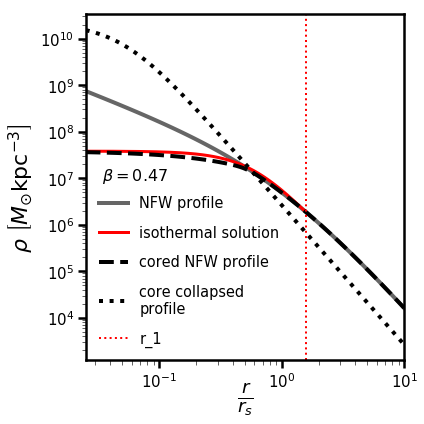

In [7]:
from sidmpy.Profiles.sidm_profile import SIDMprofile
from sidmpy.Profiles.halo_density_profiles import TNFWprofile, coreTNFWprofile, mean_density_inside_R, rho_spl, rho0_spl_rho0fromM
import numpy as np
from matplotlib import cm

prof = SIDMprofile(rho_core, velocity_dispersion, r_1, rhos, rs, xmin=0.01, xmax=10)
#prof = SIDMprofile.fromNFWparams(rhos, rs, halo_age, cross_section_type, kwargs_cross_section, xmin=0.01, xmax=10)
r = np.logspace(-1.6, 1., 100) * rs
density_composite = prof(r, smooth=True, smooth_scale=0.1, rt=5*rs)

rt = 500 * rs
rc = rhos * rs / rho_core
print(rc/rs)
density_nfw = TNFWprofile(r, rhos, rs, rt)
density_isothermal = prof.rho_isothermal
density_approx = coreTNFWprofile(r, rhos, rs, rt, rc, a=10)
 
rho0 = rho0_spl_rho0fromM(2.16, rs, rhos)
xcore = 0.05
gamma = 3.
core_collapse_approx = rho_spl(r, rho0, xcore*rs, gamma)
cmap = cm.gist_heat

fig = plt.figure(1)
fig.set_size_inches(6,6)
ax = plt.subplot(111)
ax.loglog(r/rs, density_nfw, color='0.4', label='NFW profile', lw=4)
idxmax = np.where(prof.r_iso > r_1)[0][0]
ax.loglog(prof.r_iso[0:idxmax]/rs, prof.rho_isothermal[0:idxmax], color='r', label='isothermal solution', lw=3.)
#ax.loglog(r, density_composite, color='g', linestyle='--', label='composite profile', lw=4)
ax.loglog(r/rs, density_approx, color='k', linestyle='--', label='cored NFW profile', lw=4.)
ax.loglog(r/rs, core_collapse_approx, color='k', label='core collapsed\nprofile', lw=4., linestyle=':')
ax.axvline(r_1/rs, color='r', label='r_1', lw=2, linestyle=':')
ax.annotate(r'$\beta = 0.47$', xy=(0.05, 0.52), xycoords='axes fraction', fontsize=16)
ax.legend(fontsize=14.5, frameon=False, loc=3, labelspacing=1)
ax.set_xlim(r[0]/rs, r[-1]/rs)
ax.set_xlabel(r'$\frac{r}{r_s}$', fontsize=26, labelpad=-10)
ax.set_ylabel(r'$\rho \ \left[M_{\odot} \rm{kpc^{-3}}\right]$', fontsize=22)
plt.tight_layout()
#plt.savefig('SIDMprofile.pdf')

rho_mean_collapsed = mean_density_inside_R(rs, rho_spl, (rho0, xcore * rs, gamma))
rho_mean_nfw = mean_density_inside_R(rs, TNFWprofile, (rhos, rs, rt))
print(rho_mean_collapsed/rho_mean_nfw)

## Interpolated solutions

solutions for the central core density are pre-computed and saved for a subset of possible cross section models. They are accurate to within 30% at worst, but much faster to compute. 

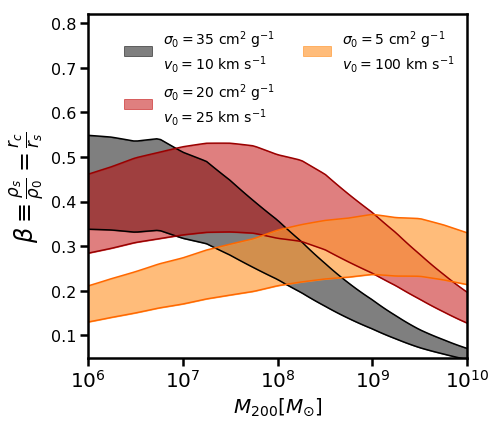

In [9]:
from pyHalo.Halos.lens_cosmo import LensCosmo
from sidmpy.sidmpy import solve_rho_with_interpolation

lc = LensCosmo()
m = np.logspace(6, 10, 100)
logm = np.log10(m)
z = 0.5
scatter_amp = 0.1
from matplotlib import cm
cmap = cm.gist_heat

fig = plt.figure(1)
ax = plt.subplot(111)
fig.set_size_inches(7,6 )
rho0values_plus, rho0values_minus, rc_over_rs_minus, rc_over_rs_plus = [], [], [], []
kwargs_cross_section = {'norm': 35, 'v_ref': 10}
for mi in m:
    c_median = lc.NFW_concentration(mi, 0.5, scatter=False)
    c_plus = 10 ** (np.log10(c_median) + scatter_amp)
    c_minus = 10 ** (np.log10(c_median) - scatter_amp)
    delta_c_plus = (c_plus - c_median) / c_median
    delta_c_minus = (c_minus - c_median) / c_median
    rho0_plus = solve_rho_with_interpolation(mi, z, delta_c_plus, cross_section_type, kwargs_cross_section)
    rho0_minus = solve_rho_with_interpolation(mi, z, delta_c_minus, cross_section_type, kwargs_cross_section)
    rhos_plus, _, _ = lc.NFW_params_physical(mi, c_plus, z)
    rhos_minus, _, _ = lc.NFW_params_physical(mi, c_minus, z)
    rho0values_plus.append(rho0_plus)
    rho0values_minus.append(rho0_minus)
    rc_over_rs_plus.append(rhos_plus/rho0values_plus[-1])
    rc_over_rs_minus.append(rhos_minus/rho0values_minus[-1])

label = r'$\sigma_0 = 35 \ \rm{cm^2} \ \rm{g^{-1}}$'+'\n'+r'$v_0 = 10 \ \rm{km} \ \rm{s^{-1}}$'
ax.fill_between(logm, rc_over_rs_minus, rc_over_rs_plus, color='k', alpha=0.5, label=label)
plt.plot(logm, rc_over_rs_minus, color='k')
plt.plot(logm, rc_over_rs_plus, color='k')

rho0values_plus, rho0values_minus, rc_over_rs_minus, rc_over_rs_plus = [], [], [], []
kwargs_cross_section = {'norm': 20, 'v_ref': 25}
for mi in m:
    c_median = lc.NFW_concentration(mi, 0.5, scatter=False)
    c_plus = 10 ** (np.log10(c_median) + scatter_amp)
    c_minus = 10 ** (np.log10(c_median) - scatter_amp)
    delta_c_plus = (c_plus - c_median) / c_median
    delta_c_minus = (c_minus - c_median) / c_median
    rho0_plus = solve_rho_with_interpolation(mi, z, delta_c_plus, cross_section_type, kwargs_cross_section)
    rho0_minus = solve_rho_with_interpolation(mi, z, delta_c_minus, cross_section_type, kwargs_cross_section)
    rhos_plus, _, _ = lc.NFW_params_physical(mi, c_plus, z)
    rhos_minus, _, _ = lc.NFW_params_physical(mi, c_minus, z)
    rho0values_plus.append(rho0_plus)
    rho0values_minus.append(rho0_minus)
    rc_over_rs_plus.append(rhos_plus/rho0values_plus[-1])
    rc_over_rs_minus.append(rhos_minus/rho0values_minus[-1])

label = r'$\sigma_0 = 20 \ \rm{cm^2} \ \rm{g^{-1}}$'+'\n'+r'$v_0 = 25 \ \rm{km} \ \rm{s^{-1}}$'
ax.fill_between(logm, rc_over_rs_minus, rc_over_rs_plus, color=cmap(0.5), alpha=0.5, label=label)
plt.plot(logm, rc_over_rs_minus, color=cmap(0.4))
plt.plot(logm, rc_over_rs_plus, color=cmap(0.4))

rho0values_plus, rho0values_minus, rc_over_rs_minus, rc_over_rs_plus = [], [], [], []
kwargs_cross_section = {'norm': 5, 'v_ref': 100}
for mi in m:
    c_median = lc.NFW_concentration(mi, 0.5, scatter=False)
    c_plus = 10 ** (np.log10(c_median) + scatter_amp)
    c_minus = 10 ** (np.log10(c_median) - scatter_amp)
    delta_c_plus = (c_plus - c_median) / c_median
    delta_c_minus = (c_minus - c_median) / c_median
    rho0_plus = solve_rho_with_interpolation(mi, z, delta_c_plus, cross_section_type, kwargs_cross_section)
    rho0_minus = solve_rho_with_interpolation(mi, z, delta_c_minus, cross_section_type, kwargs_cross_section)
    rhos_plus, _, _ = lc.NFW_params_physical(mi, c_plus, z)
    rhos_minus, _, _ = lc.NFW_params_physical(mi, c_minus, z)
    rho0values_plus.append(rho0_plus)
    rho0values_minus.append(rho0_minus)
    rc_over_rs_plus.append(rhos_plus/rho0values_plus[-1])
    rc_over_rs_minus.append(rhos_minus/rho0values_minus[-1])

label = r'$\sigma_0 = 5 \ \rm{cm^2} \ \rm{g^{-1}}$'+'\n'+r'$v_0 = 100 \ \rm{km} \ \rm{s^{-1}}$'
third = ax.fill_between(logm, rc_over_rs_minus, rc_over_rs_plus, color=cmap(0.8), alpha=0.65, label=label)
ax.plot(logm, rc_over_rs_minus, color=cmap(0.7))
ax.plot(logm, rc_over_rs_plus, color=cmap(0.7))
lines = ax.get_lines()
ax.set_xticks([6, 7, 8, 9, 10])
ax.set_xticklabels([r'$10^{6}$', r'$10^{7}$', r'$10^{8}$', r'$10^{9}$', r'$10^{10}$'], fontsize=20)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=16)
leg1 = ax.legend(fontsize=14, loc=1, ncol=2, frameon=False)
ax.set_xlim(6, 10)
ax.set_ylim(0.05, 0.82)
ax.set_xlabel(r'$M_{200} \left[M_{\odot}\right]$', fontsize=20)
ax.set_ylabel(r'$\beta \equiv \frac{\rho_s}{\rho_0} = \frac{r_c}{r_s}$', fontsize=24)
plt.tight_layout()
#plt.savefig('core_sizes.pdf')